# Import Libraries

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
from IPython.display import HTML
import seaborn as sns
import pandas as pd
import numpy as np


import cv2 as cv
import rasterio


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K



from sklearn.metrics import *
from sklearn.model_selection import train_test_split


import pickle
from pathlib import Path
from PIL import Image
import tifffile as tiff


import os
import random

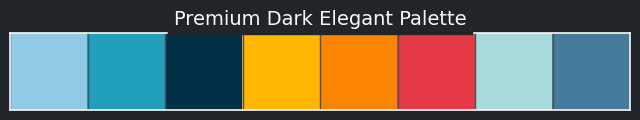

In [16]:
# Define a premium dark elegant color palette
dark_elegant_palette = [
    "#8ecae6",  # Light Blue Accent
    "#219ebc",  # Medium Blue
    "#023047",  # Deep Navy
    "#ffb703",  # Warm Yellow
    "#fb8500",  # Warm Orange
    "#e63946",  # Muted Red
    "#a8dadc",  # Soft Mint
    "#457b9d",  # Slate Blue
]

# Set a dark theme for Seaborn
sns.set_theme(
    style="darkgrid",              # Dark grid background
    palette=dark_elegant_palette,  # Custom color palette
    font="DejaVu Sans",
    rc={
        "axes.facecolor": "#212529",     # Dark background for axes
        "figure.facecolor": "#212529",   # Dark background for figure
        "axes.edgecolor": "#f8f9fa",     # Light axis lines
        "axes.labelcolor": "#f8f9fa",    # Light axis labels
        "text.color": "#f8f9fa",         # Light text
        "xtick.color": "#f8f9fa",        # Light tick labels
        "ytick.color": "#f8f9fa",
        "grid.color": "#495057",         # Muted gridlines
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "figure.figsize": (8, 5),
        "axes.linewidth": 1.2,
    }
)

# Apply the palette to Matplotlib
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=dark_elegant_palette)

# Preview the palette
sns.palplot(dark_elegant_palette)
plt.title("Premium Dark Elegant Palette", fontsize=14, color="#f8f9fa", backgroundcolor="#212529")
plt.show()

# Get and Explore Data

In [4]:
labels_path = '/content/drive/MyDrive/data/water_segmentation_data/labels'
images_path = '/content/drive/MyDrive/data/water_segmentation_data/images'

In [5]:
print(f"number of the labels = {len(os.listdir(labels_path))}")
print(f"number of the images = {len(os.listdir(images_path))}")

number of the labels = 306
number of the images = 306


In [6]:
def check_bad_images(base_path):
    bad_images = []
    good_images = []
    for file in (os.listdir(base_path)):
        if '_' in file:
            bad_images.append( file)
            os.remove(os.path.join(base_path, file))


    print("Bad images:", bad_images)

In [7]:
images = check_bad_images(images_path)

Bad images: []


In [8]:
labels = check_bad_images(labels_path)

Bad images: []


In [ ]:
image_path = '/content/drive/MyDrive/data/water_segmentation_data/images/277.tif'

with rasterio.open(image_path) as img:
    print(f"Total Bands: {img.count}")
    for i in range(1, img.count + 1):
        channel = img.read(i)
        print(f"Band {i}: Shape {channel.shape}, Min {channel.min()}, Max {channel.max()}")

| Band | Predicted Name               | Shape    | Min  | Max  | Notes                                                                 |
|------|------------------------------|----------|------|------|-----------------------------------------------------------------------|
| 1    | Coastal Aerosol              | 128×128  | 15   | 685  | Detects haze/coastal features. Low reflectance range.                 |
| 2    | Blue                         | 128×128  | 70   | 1685 | Water penetration band. Higher max suggests vegetation influence.    |
| 3    | Green                        | 128×128  | 177  | 2009 | Chlorophyll reflectance peak. Critical for NDWI.                      |
| 4    | Red                          | 128×128  | 268  | 2130 | Strong water absorption. Land/vegetation shows high reflectance.      |
| 5    | NIR (Near-Infrared)          | 128×128  | 3    | 2905 | Near-zero = water. Max = healthy vegetation. Key for water masking.   |
| 6    | SWIR1                        | 128×128  | -134 | 3606 | Moisture-sensitive. Negative values may need clipping.                |
| 7    | SWIR2                        | 128×128  | -60  | 3310 | Stronger water absorption than SWIR1. Dry land shows high values.     |
| 8    | Panchromatic                 | 128×128  | 64   | 240  | High-res band. Narrow range suggests grayscale enhancement.           |
| 9    | Cirrus                       | 128×128  | 110  | 128  | Detects high-altitude ice clouds. Minimal variation in this scene.    |
| 10   | Thermal Infrared 1 (TIRS1)    | 128×128  | 104  | 150  | Surface temperature. Stable values suggest uniform thermal profile.   |
| 11   | Thermal Infrared 2 (TIRS2)    | 128×128  | 10   | 80   | Secondary thermal band. May require atmospheric correction.           |
| 12   | Water Occurrence/QA Band      | 128×128  | 0    | 96   | Likely water probability (0-100%) or quality flags.                   |

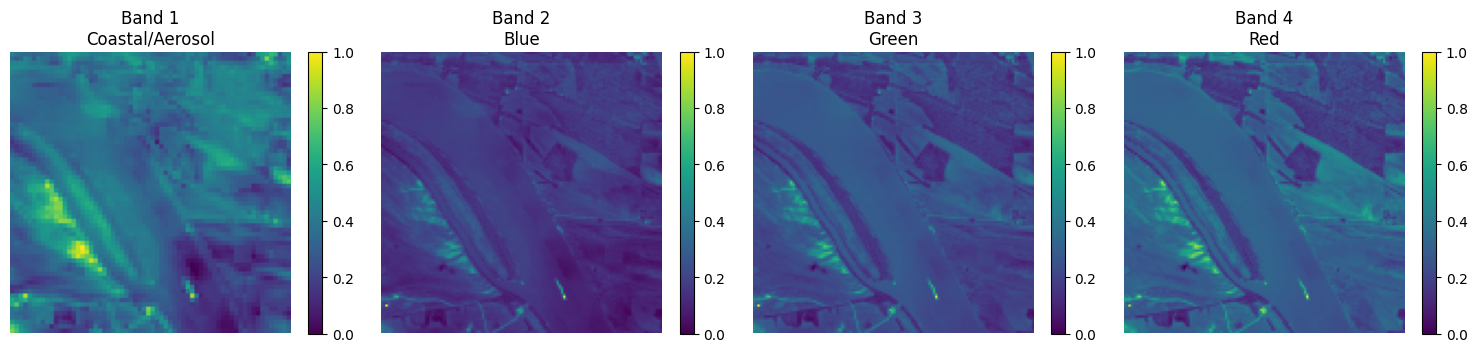

In [9]:
# Construct the full path to the target image file
img_file = os.path.join(images_path, '277.tif')
img_data = tiff.imread(img_file)

# Function to scale pixel values of a single channel to the range [0, 1]
def scale_channel(channel_data):
    min_pixel = np.min(channel_data)
    max_pixel = np.max(channel_data)
    return (channel_data - min_pixel) / (max_pixel - min_pixel)

# Define bands to display
selected_bands = {
    1: 'Coastal/Aerosol',
    2: 'Blue',
    3: 'Green',
    4: 'Red'
}

# Create a grid to display all bands together
fig, axes = plt.subplots(1, len(selected_bands), figsize=(15, 5))  # 1 row, N columns

for ax, (idx, name) in zip(axes, selected_bands.items()):
    scaled_band = scale_channel(img_data[:, :, idx - 1])
    im = ax.imshow(scaled_band, cmap='viridis')
    ax.set_title(f'Band {idx}\n{name}')
    ax.axis('off')  # Hide axis ticks
    fig.colorbar(im, ax=ax, shrink=0.6)  # Add color bar to each subplot

plt.tight_layout()
plt.show()


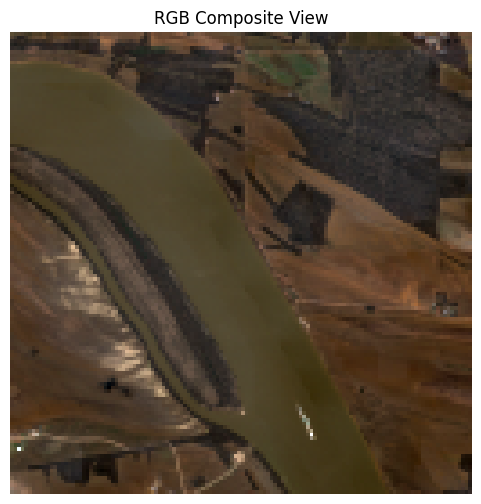

In [10]:
# Extract and normalize the bands for RGB composition
red = scale_channel(img_data[:, :, 3])    # Red band (Band 4)
green = scale_channel(img_data[:, :, 2])  # Green band (Band 3)
blue = scale_channel(img_data[:, :, 1])   # Blue band (Band 2)

# Combine the bands into a single RGB image
rgb_composite = np.dstack((red, green, blue))

# Display the RGB composite image
plt.figure(figsize=(6, 6))
plt.imshow(rgb_composite)
plt.title('RGB Composite View')
plt.axis('off')  # Hide axis ticks for a cleaner look
plt.show()


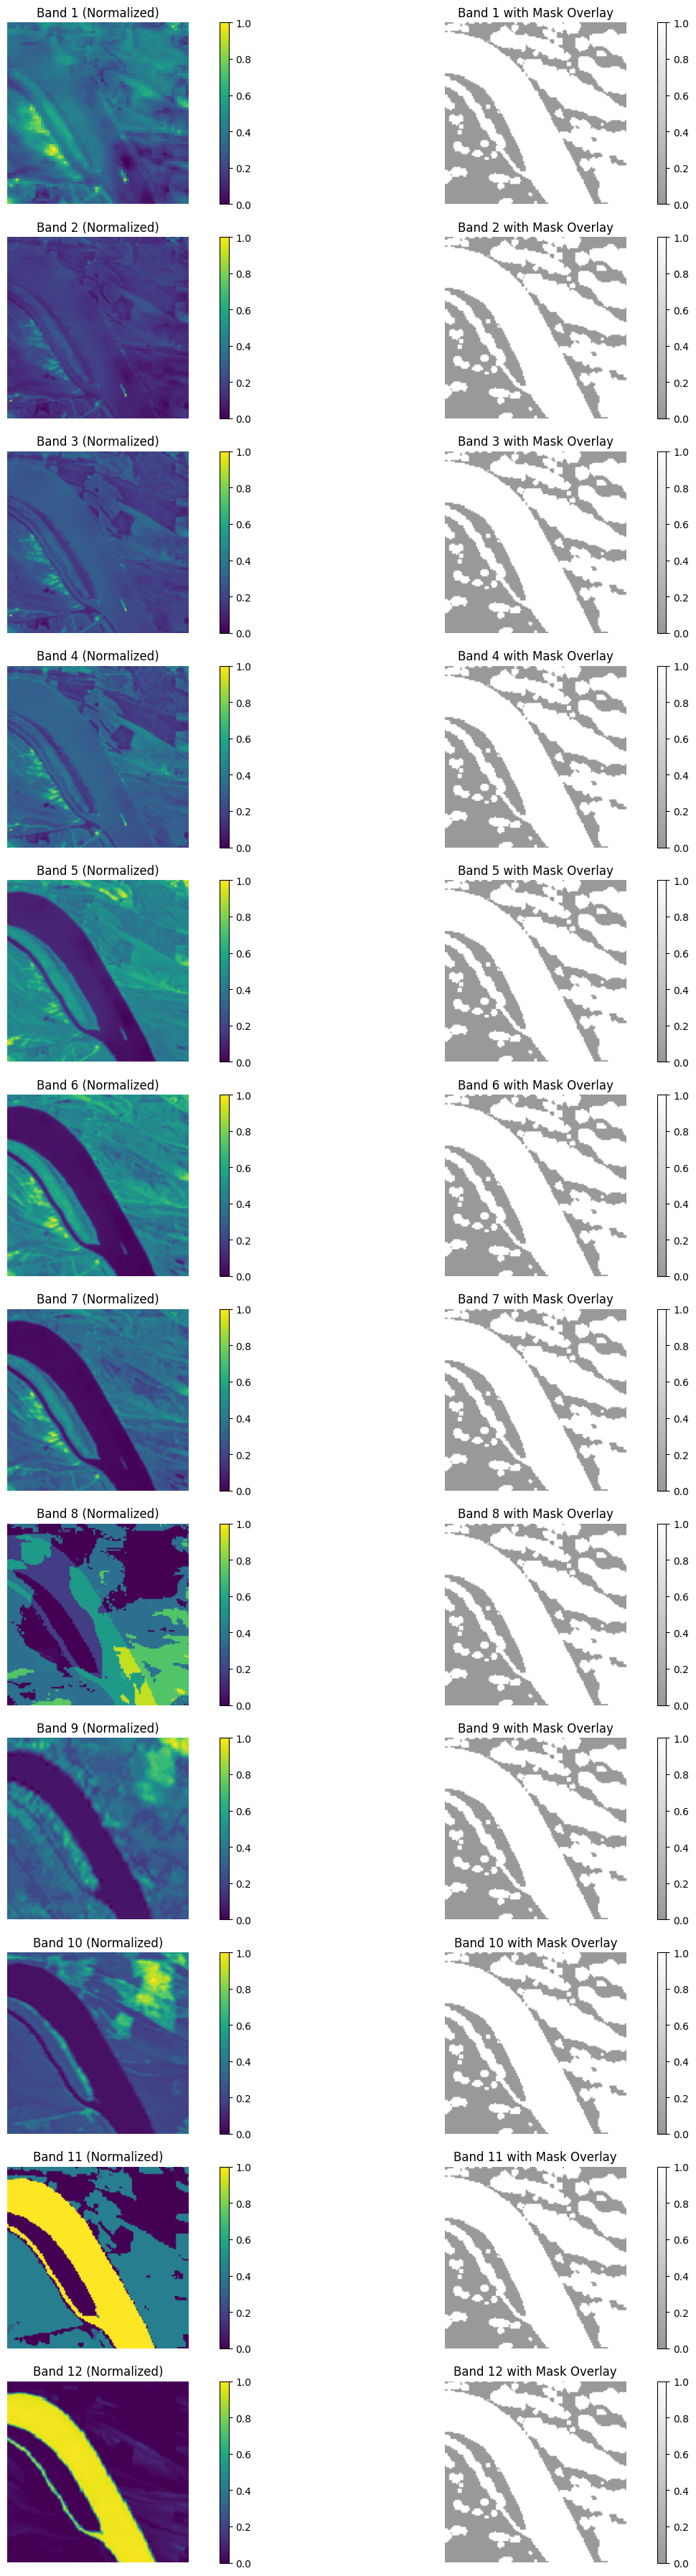

In [11]:
# Function to scale pixel values of a single channel to the range [0, 1]
def scale_channel(channel_data):
    min_pixel = np.min(channel_data)
    max_pixel = np.max(channel_data)
    # Handle cases where min_pixel equals max_pixel to avoid division by zero
    if max_pixel == min_pixel:
        return np.zeros_like(channel_data, dtype=np.float32)
    return (channel_data - min_pixel) / (max_pixel - min_pixel)

# Load the mask image
mask_file = os.path.join(labels_path, '277.png')  # Update path if necessary
mask_data = plt.imread(mask_file)

# Ensure mask is binary (0 or 1)
# Assuming the mask is grayscale and water is represented by a specific value (e.g., white)
# You might need to adjust the threshold based on your mask data
mask_binary = (mask_data > 0).astype(np.uint8)


# Construct the full path to the target image file
img_file = os.path.join(images_path, '277.tif')
img_data = tiff.imread(img_file)

# Get the number of bands
num_bands = img_data.shape[2]

# Create plots for each band with mask overlay
plt.figure(figsize=(15, num_bands * 3)) # Adjust figure size based on number of bands

for band_idx in range(num_bands):
    band_data = img_data[:, :, band_idx]
    scaled_band = scale_channel(band_data)

    plt.subplot(num_bands, 2, 2 * band_idx + 1)
    plt.imshow(scaled_band, cmap='viridis')
    plt.title(f'Band {band_idx + 1} (Normalized)')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(num_bands, 2, 2 * band_idx + 2)
    # plt.imshow(scaled_band, cmap='viridis', alpha=0.6) # Base layer
    plt.imshow(mask_binary, cmap='gray', alpha=0.4) # Overlay mask
    plt.title(f'Band {band_idx + 1} with Mask Overlay')
    plt.colorbar()
    plt.axis('off')

plt.tight_layout()
plt.show()

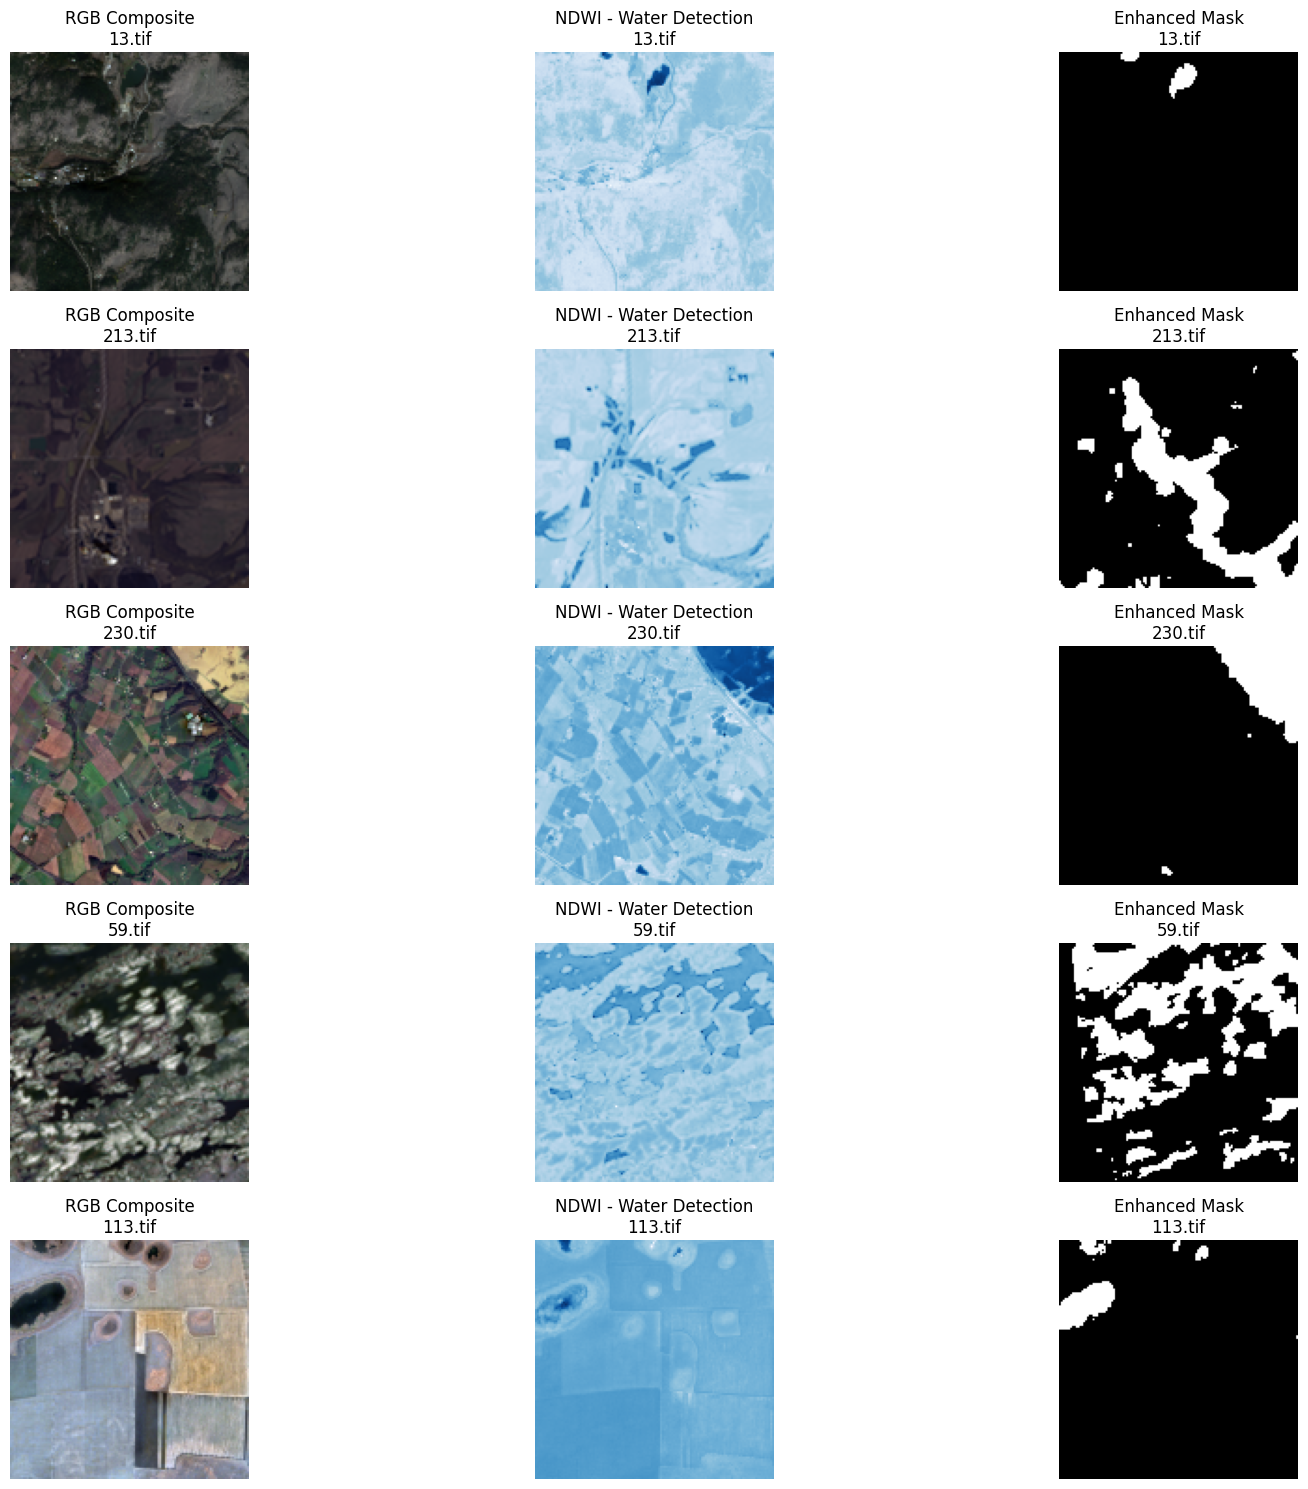

In [12]:
def scale_band(band):
    """Scale band values to [0, 1] for visualization."""
    return (band - np.min(band)) / (np.max(band) - np.min(band) + 1e-8)

def enhance_mask(mask):
    """
    Enhance the contrast of a mask image.
    Assumes mask pixel values are in [0, 1].
    """
    mask_array = np.array(mask)
    enhanced = (mask_array * 255).clip(0, 255).astype(np.uint8)
    return enhanced

def process_and_visualize(images_dir, masks_dir, num_samples=10):
    """
    Randomly select images and visualize:
    - RGB composite
    - NDWI (water index)
    - Enhanced mask overlay
    """
    images_path = Path(images_dir)
    masks_path = Path(masks_dir)

    # Get random sample of .tif files
    tif_files = list(images_path.glob('*.tif'))
    if num_samples > len(tif_files):
        raise ValueError(f"Requested {num_samples} samples but only found {len(tif_files)} images.")

    selected_files = random.sample(tif_files, num_samples)

    # Create a figure with 3 columns: RGB, NDWI, Mask
    fig, axes = plt.subplots(num_samples, 3, figsize=(18, num_samples * 3))

    for i, img_file in enumerate(selected_files):
        # Load image and corresponding mask
        img = tiff.imread(img_file)
        mask_file = masks_path / (img_file.stem + ".png")
        mask = Image.open(mask_file)

        # Process bands
        blue = scale_band(img[:, :, 1])   # Band 2
        green = scale_band(img[:, :, 2])  # Band 3
        red = scale_band(img[:, :, 3])    # Band 4
        nir = scale_band(img[:, :, 4])    # Band 5

        rgb_composite = np.dstack((red, green, blue))
        ndwi = (green - nir) / (green + nir + 1e-8)
        mask_enhanced = enhance_mask(mask)

        # Plot RGB composite
        ax_rgb = axes[i, 0] if num_samples > 1 else axes[0]
        ax_rgb.imshow(rgb_composite)
        ax_rgb.set_title(f'RGB Composite\n{img_file.name}')
        ax_rgb.axis('off')

        # Plot NDWI
        ax_ndwi = axes[i, 1] if num_samples > 1 else axes[1]
        ax_ndwi.imshow(ndwi, cmap='Blues')
        ax_ndwi.set_title(f'NDWI - Water Detection\n{img_file.name}')
        ax_ndwi.axis('off')

        # Plot enhanced mask
        ax_mask = axes[i, 2] if num_samples > 1 else axes[2]
        ax_mask.imshow(mask_enhanced, cmap='gray')
        ax_mask.set_title(f'Enhanced Mask\n{img_file.name}')
        ax_mask.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
process_and_visualize(images_dir=images_path, masks_dir=labels_path, num_samples=5)


# Preprocessing

In [17]:
def load_images_and_masks(images_dir, masks_dir, mask_threshold=0):
    """
    Load all .tif images and their corresponding masks.

    Args:
        images_dir (str or Path): Path to directory containing .tif images.
        masks_dir (str or Path): Path to directory containing mask images (.png).
        mask_threshold (int): Pixel values above this threshold are set to 1.

    Returns:
        images (np.ndarray): Array of loaded images.
        masks (np.ndarray): Array of binary masks.
    """
    images_path = Path(images_dir)
    masks_path = Path(masks_dir)

    image_files = sorted(images_path.glob('*.tif'))  # Sorted for consistent order

    images = []
    masks = []

    for img_file in image_files:
        # Load image
        img = tiff.imread(img_file)

        # Locate corresponding mask
        mask_file = masks_path / (img_file.stem + ".png")
        if not mask_file.exists():
            print(f"⚠️ Warning: Mask not found for {img_file.name}. Skipping.")
            continue

        # Load and binarize mask
        mask = np.array(Image.open(mask_file))
        binary_mask = (mask > mask_threshold).astype(np.uint8)

        images.append(img)
        masks.append(binary_mask)

    # Convert lists to numpy arrays
    images = np.array(images)
    masks = np.array(masks)

    print(f"✅ Loaded {len(images)} images with shape {images.shape}")
    print(f"✅ Loaded {len(masks)} masks with shape {masks.shape}")

    return images, masks

# Example usage
images, masks = load_images_and_masks(images_path, labels_path)


✅ Loaded 306 images with shape (306, 128, 128, 12)
✅ Loaded 306 masks with shape (306, 128, 128)


In [18]:
def normalize_image(image):
    """
    Normalize each band of a multi-channel image to [0, 1].
    If a band has constant values (min == max), fill it with zeros.

    Args:
        image (np.ndarray): Multi-channel image (H x W x C).

    Returns:
        np.ndarray: Normalized image with dtype float32.
    """
    norm_img = np.zeros_like(image, dtype=np.float32)

    for band_idx in range(image.shape[2]):
        band = image[:, :, band_idx]
        min_val, max_val = np.min(band), np.max(band)
        if max_val > min_val:
            norm_img[:, :, band_idx] = (band - min_val) / (max_val - min_val)
        else:
            norm_img[:, :, band_idx] = 0.0  # Constant value if band is flat

    return norm_img
images_normalized = np.array([normalize_image(img) for img in images])

In [19]:
# Select specific bands (0-indexed)
selected_bands_indices = [1, 2, 3, 4, 5, 6, 11]
images_selected_bands = images_normalized[:, :, :, selected_bands_indices]

print(f"Shape of images with selected bands: {images_selected_bands.shape}")



Shape of images with selected bands: (306, 128, 128, 7)


In [20]:
X_train, X_val, y_train, y_val = train_test_split(images_selected_bands, masks, test_size=0.3, random_state=42)

In [23]:
print(f"Train_x:{len(X_train)}")
print(f"Train_y:{len(y_train)}")

print(f"Test_x:{len(X_val)}")
print(f"Test_y:{len(y_val)}")

Train_x:214
Train_y:214
Test_x:92
Test_y:92


In [25]:
print(np.isnan(images).sum(), np.isinf(images).sum())
print(np.isnan(images_selected_bands).sum(), np.isinf(images_selected_bands).sum())
print(np.isnan(images_normalized).sum(), np.isinf(images_normalized).sum())
print(np.isnan(masks).sum(), np.isinf(masks).sum())

0 0
0 0
0 0
0 0


# Modeling

## trying first one

In [65]:

def unet_model(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c2])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c1])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model



model = unet_model(input_shape=(128, 128, 7))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # use another loss function

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=7, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-5, verbose=1),
]


history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=8,
    callbacks=callbacks,
    batch_size=32
)


Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5757 - loss: 0.6141 - val_accuracy: 0.8889 - val_loss: 0.4092 - learning_rate: 0.0010
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - accuracy: 0.8892 - loss: 0.3784 - val_accuracy: 0.8959 - val_loss: 0.3149 - learning_rate: 0.0010
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.8963 - loss: 0.3144 - val_accuracy: 0.8988 - val_loss: 0.2925 - learning_rate: 0.0010
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - accuracy: 0.8987 - loss: 0.2976 - val_accuracy: 0.9016 - val_loss: 0.2871 - learning_rate: 0.0010
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.9107 - loss: 0.2765 - val_accuracy: 0.8898 - val_loss: 0.3223 - learning_rate: 0.0010
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - accuracy: 0.8907 - loss: 0.3119 - val_accuracy: 0.8932 - val_loss: 0.2889 - learning_rate: 0.0010
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - accuracy: 0.9018 - loss: 0.2698 - val_accuracy: 0.9047 - 

In [62]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 7)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 128, 128,  │      4,096 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_55[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 64, 64,    │          0 │ conv2d_56[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_57[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 32, 32,    │          0 │ conv2d_58[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_11… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_59[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_10 │ (None, 64, 64,    │    131,200 │ conv2d_60[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_58[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 64, 64,    │    295,040 │ concatenate_10[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_61[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_11 │ (None, 128, 128,  │     32,832 │ conv2d_62[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_56[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 128, 128,  │     73,792 │ concatenate_11[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_63[0][0] 

 Total params: 5,595,461 (21.34 MB)

 Trainable params: 1,865,153 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,730,308 (14.23 MB)

In [66]:

def unet_model(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c2])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c1])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model




model = unet_model(input_shape=(128, 128, 7))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=7, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-5, verbose=1),
]


history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    callbacks=callbacks,
    batch_size=32
)


Epoch 1/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 852ms/step - accuracy: 0.5583 - loss: 0.6118 - val_accuracy: 0.8867 - val_loss: 0.3437 - learning_rate: 0.0010
Epoch 2/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - accuracy: 0.8797 - loss: 0.3646 - val_accuracy: 0.9012 - val_loss: 0.3047 - learning_rate: 0.0010
Epoch 3/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.8973 - loss: 0.3090 - val_accuracy: 0.8981 - val_loss: 0.2897 - learning_rate: 0.0010
Epoch 4/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - accuracy: 0.8953 - loss: 0.3018 - val_accuracy: 0.9030 - val_loss: 0.2858 - learning_rate: 0.0010
Epoch 5/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - accuracy: 0.9028 - loss: 0.2850 - val_accuracy: 0.9048 - val_loss: 0.2801 - learning_rate: 0.0010
Epoch 6/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - accuracy: 0.9077 - loss: 0.2723 - val_accuracy: 0.9063 - val_loss: 0.2804 - learning_rate: 0.0010
Epoch 7/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.8969 - loss: 0.2884 - val_accuracy:

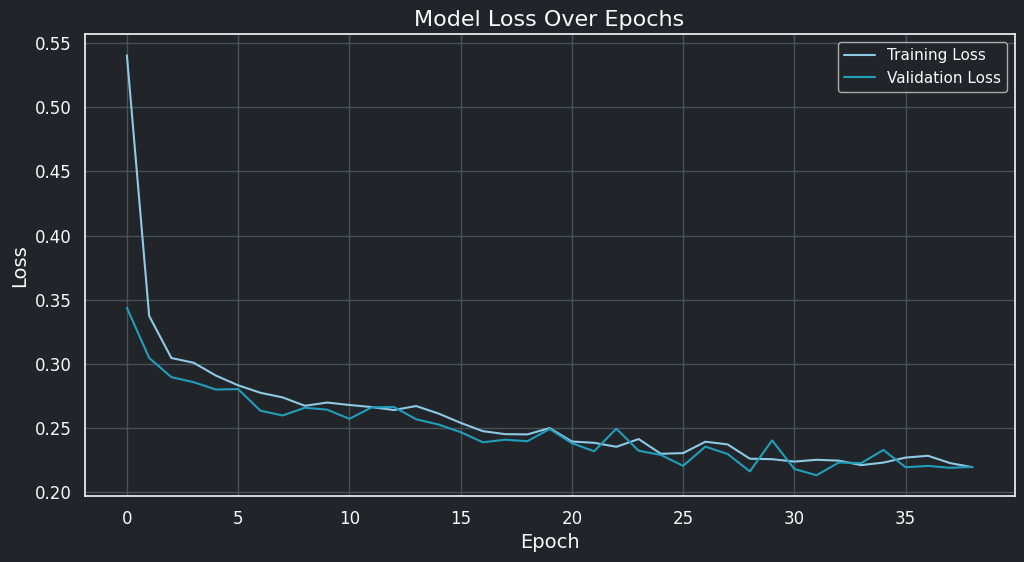

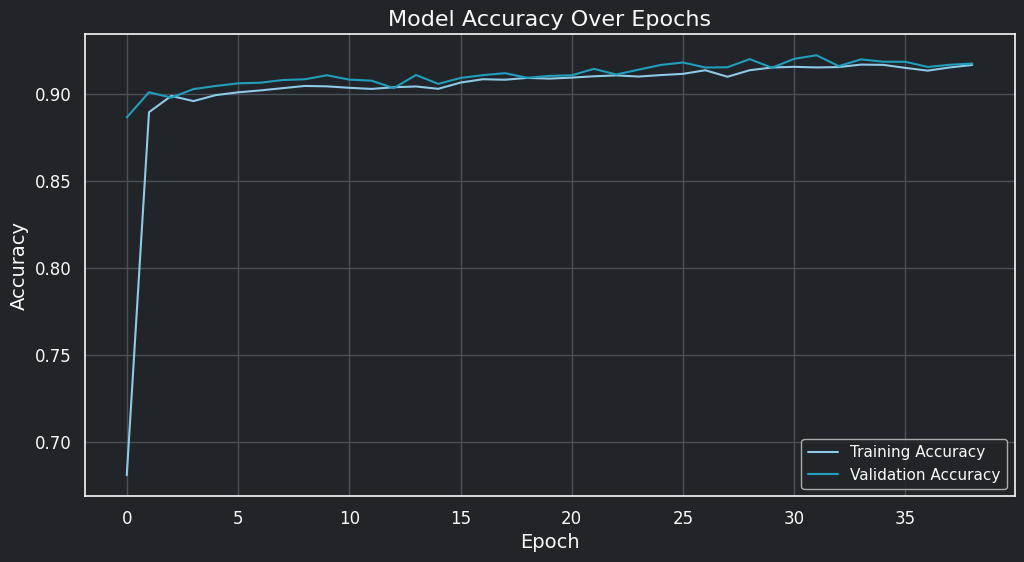

In [67]:
# plot accuracy and loss
# Plot loss for both phases
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'] , label='Training Loss')
plt.plot(history.history['val_loss'] , label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot accuracy for both phases
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'] , label='Training Accuracy')
plt.plot(history.history['val_accuracy'] , label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


## try another approach

In [37]:
def unit_model2(input_shape=(128,128,7), dropout_rate=0.3):
    inputs = keras.Input(input_shape)

    # Encoder
    x = layers.Conv2D(64, 3, strides=2, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2D(128, 3, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2D(256, 3, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Dropout(dropout_rate)(x)  # Regularization

    # Decoder
    x = layers.Conv2DTranspose(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2DTranspose(256, 3, padding="same", strides=2, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2DTranspose(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2DTranspose(128, 3, padding="same", strides=2, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2DTranspose(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = layers.Conv2DTranspose(64, 3, padding="same", strides=2, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = keras.Model(inputs, outputs)

    return model

In [38]:
model2 = unit_model2()

In [55]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    # تأكد من أن الأشكال متوافقة
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # تقليل الأبعاد إذا لزم الأمر
    if len(y_true.shape) == 4:
        y_true = tf.squeeze(y_true, axis=-1)
    if len(y_pred.shape) == 4:
        y_pred = tf.squeeze(y_pred, axis=-1)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

def iou(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    # تقليل الأبعاد إذا لزم الأمر
    if len(y_true.shape) == 4:
        y_true = tf.squeeze(y_true, axis=-1)
    if len(y_pred.shape) == 4:
        y_pred = tf.squeeze(y_pred, axis=-1)

    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + K.epsilon())

In [61]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy",dice_coefficient, iou]
)


checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "best_unet_model.keras",  # File name
    monitor="val_iou",  # Track validation IoU
    mode="max",  # Save when IoU is highest
    save_best_only=True,
    verbose=1
)


history2 = model2.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    callbacks=[checkpoint_callback],
    batch_size=32
)


Epoch 1/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.9397 - dice_coefficient: 0.8329 - iou: 0.8030 - loss: 0.1502
Epoch 1: val_iou improved from -inf to 0.66362, saving model to best_unet_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9397 - dice_coefficient: 0.8320 - iou: 0.8020 - loss: 0.1502 - val_accuracy: 0.9191 - val_dice_coefficient: 0.6574 - val_iou: 0.6636 - val_loss: 0.2272
Epoch 2/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9428 - dice_coefficient: 0.8383 - iou: 0.8044 - loss: 0.1434
Epoch 2: val_iou improved from 0.66362 to 0.66501, saving model to best_unet_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.9422 - dice_coefficient: 0.8368 - iou: 0.8022 - loss: 0.1448 - val_accuracy: 0.9201 - val_dice_coefficient: 0.6702 - val_iou: 0.6650 - val_loss: 0.2172
Epoch 3/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9360 - dice_coefficient: 0.8178 - iou: 0.7804 - loss: 0.1534
Epoch 3: val_iou improved from 0.66501 to 0

In [63]:
model2.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128, 128, 7)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 64, 64, 64)     │         4,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 64, 64, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 32, 32, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 32, 32, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 16, 16, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 16, 16, 256)    │       589,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 16, 16, 256)    │       589,824 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,652,805 (33.01 MB)

 Trainable params: 2,883,073 (11.00 MB)

 Non-trainable params: 3,584 (14.00 KB)

 Optimizer params: 5,766,148 (22.00 MB)

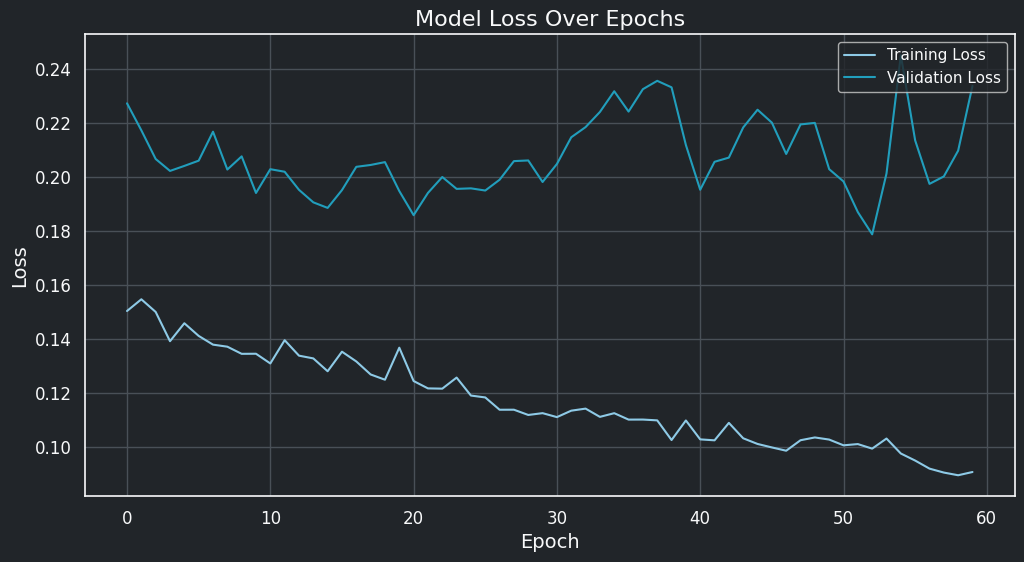

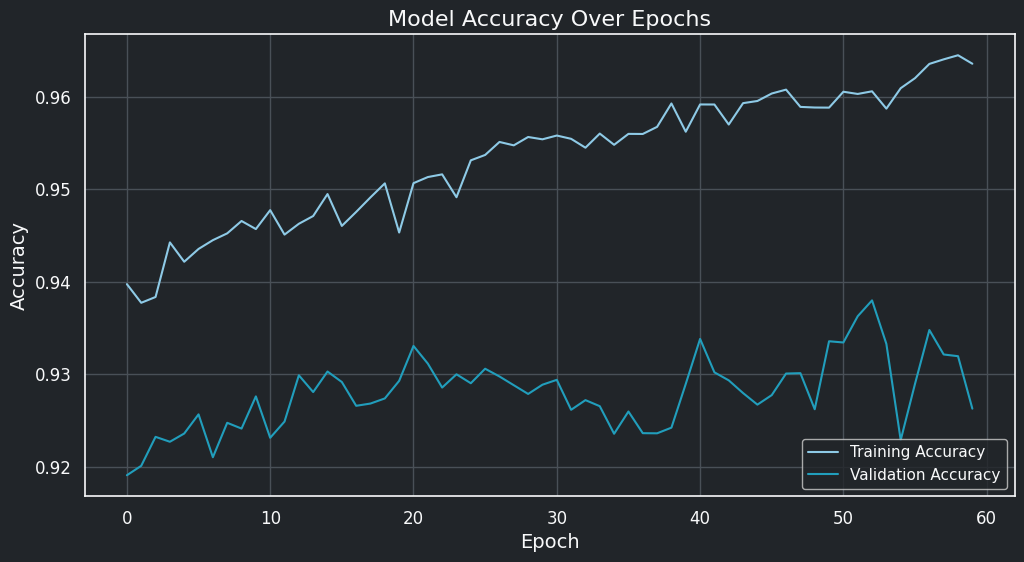

In [64]:
# plot accuracy and loss
# Plot loss for both phases
plt.figure(figsize=(12, 6))
plt.plot(history2.history['loss'] , label='Training Loss')
plt.plot(history2.history['val_loss'] , label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot accuracy for both phases
plt.figure(figsize=(12, 6))
plt.plot(history2.history['accuracy'] , label='Training Accuracy')
plt.plot(history2.history['val_accuracy'] , label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## testing the best model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


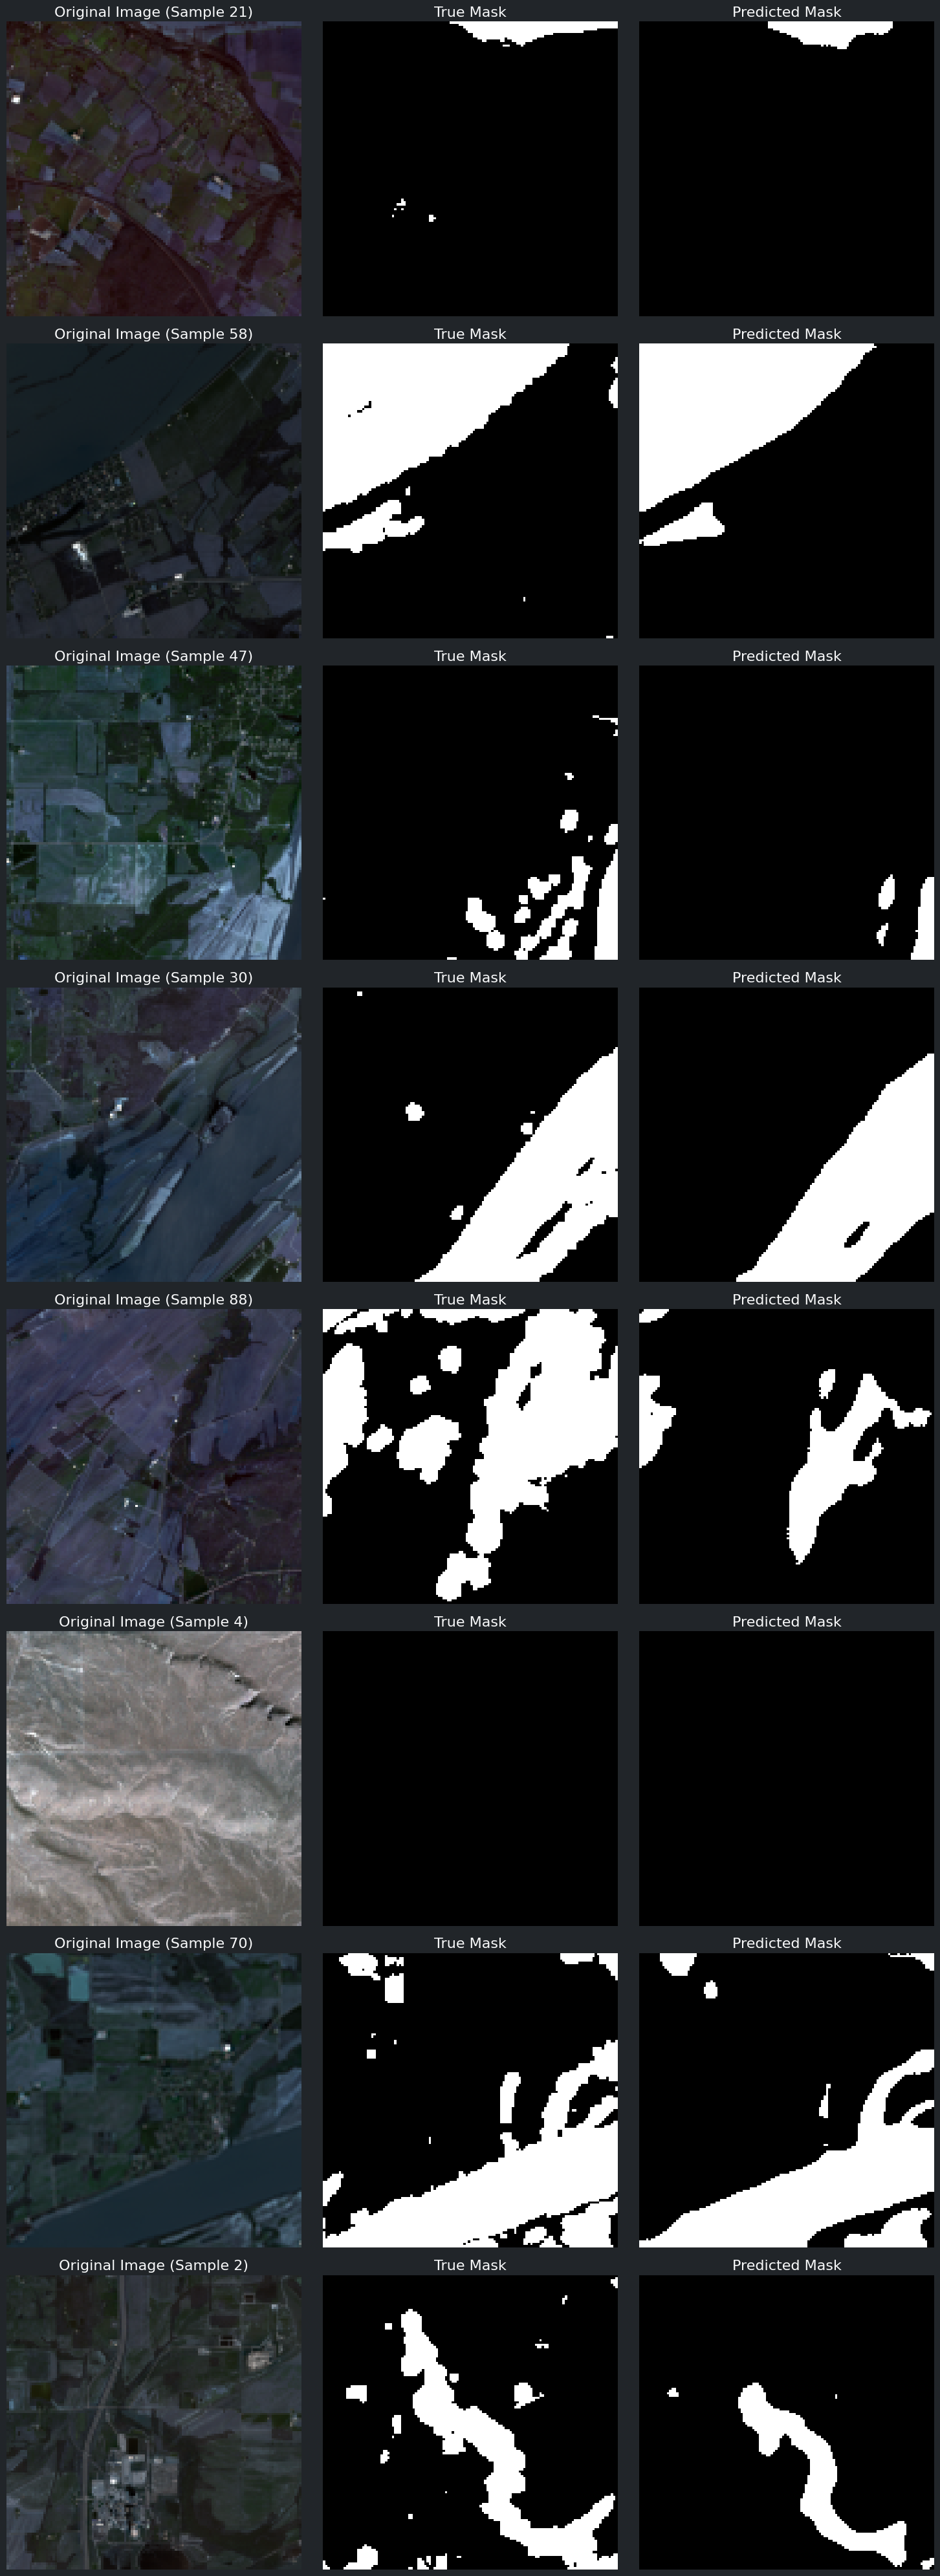

In [71]:
from tensorflow.keras.models import load_model

# Load the best model
best_model_path = '/content/best_unet_model.keras'
loaded_model = load_model(best_model_path, custom_objects={'dice_coefficient': dice_coefficient, 'iou': iou})

# Select 4 random images from the test set
num_test_images = 8
random_indices = random.sample(range(len(X_val)), num_test_images)

plt.figure(figsize=(15, num_test_images * 5))

for i, idx in enumerate(random_indices):
    # Get the original image, true mask, and predicted mask
    original_image = X_val[idx]
    true_mask = y_val[idx]
    predicted_mask = loaded_model.predict(np.expand_dims(original_image, axis=0))[0]
    predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8) # Binarize prediction

    # Plot original image (using a few bands for visualization)
    plt.subplot(num_test_images, 3, i * 3 + 1)
    # Assuming bands 3, 2, 1 (0-indexed) are suitable for an RGB-like composite
    # Adjust indices if your selected bands are different and you want a specific composite
    # If not an RGB composite, you can display a single band or a grayscale version
    if original_image.shape[-1] >= 3:
         # Attempt to create a simple RGB composite from the first 3 selected bands
         # Note: This might not be a true color composite depending on which bands were selected
         display_img = original_image[:, :, :3]
         plt.imshow(display_img)
    else:
        # If less than 3 bands, display the first band in grayscale
        plt.imshow(original_image[:, :, 0], cmap='gray')

    plt.title(f'Original Image (Sample {idx})')
    plt.axis('off')

    # Plot true mask
    plt.subplot(num_test_images, 3, i * 3 + 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title('True Mask')
    plt.axis('off')

    # Plot predicted mask
    plt.subplot(num_test_images, 3, i * 3 + 3)
    plt.imshow(predicted_mask_binary, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()